<a href="https://colab.research.google.com/github/jacksone1/DataSci/blob/main/DataSciUnit4Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Install and import datasets and preliz libraries
!pip install datasets
from datasets import load_dataset

!pip install preliz
import preliz as pz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 514.2/514.2 kB 13.3 MB/s eta 0:00:00
   

In [2]:
#Import other libraries
import numpy as np
import arviz as az
import pymc as pm
import pandas as pd
import random as rd
from matplotlib import pyplot as plt
import seaborn as sns

In the game Super Mario Maker 2, players design their own Mario levels and share them online for others to play. Each level has a "clear rate," the proportion of level attempts that are successful. Each level is also given its own difficulty value by the game as categorized below. My goal is to predict level clear rate grouped by difficulty value.

In [3]:
difficulties = {
    0: "Easy",
    1: "Normal",
    2: "Expert",
    3: "Super expert"
}

The Mario Maker 2 data used for this project was acquired from https://huggingface.co/datasets/TheGreatRambler/mm2_level. The dataset contains a variety of information about player uploaded levels, including the attempts, clears, and difficulties.

The dataset is too large to load quickly in its entirety, so it is loaded in streaming mode, which means only part of the dataset is loaded at a time. 1000 entries of level data are acquired and shuffled, before the attempts, clears, and difficulty of each level is recorded in a dictionary. The dictionary is then converted to a pandas dataframe.

The random seed used for acquiring the data was generated from Random.org's random integer generator from 1 to 100 (both inclusive) at 2024-11-12 18:49:30 UTC

In [4]:
#Read Mario Maker data
mario_levels = load_dataset("TheGreatRambler/mm2_level", streaming=True, split="train")
#Shuffle data
shuffled_levels = mario_levels.shuffle(buffer_size=1_000, seed=72)
#Get the data as a list to iterate over
sample = list(shuffled_levels.take(1000))
#Create a dictionary to hold difficulties, attempts, and clears
level_data_dict = {"difficulty": [], "clears": [], "attempts": []}
#For each element of the list, record the relevant level data
for i in range(0, 1000):
  level_data_dict["difficulty"].append(sample[i]["difficulty"])
  level_data_dict["clears"].append(sample[i]["clears"])
  level_data_dict["attempts"].append(sample[i]["attempts"])
#Convert the dictionary to a pandas dataframe
level_data_df = pd.DataFrame(level_data_dict)
#Convert difficulty to a category
level_data_df["difficulty"] = level_data_df["difficulty"].astype('category')
#Display the dataframe
level_data_df

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/15.1k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/196 [00:00<?, ?it/s]

dataset_infos.json:   0%|          | 0.00/5.51k [00:00<?, ?B/s]

,difficulty,clears,attempts
0,0,17,25
1,3,1,129
2,1,14,81
3,1,13,42
4,1,11,71
...,...,...,...
995,2,2,40
996,0,20,32
997,1,2,6
998,0,319,803


The distributions of clears, attempts, and clear rate will be plotted for all recorded levels. My hyperprior for mu will be based on the clear rate distribution, and my hyperprior for nu will be based on the attempts distribution.

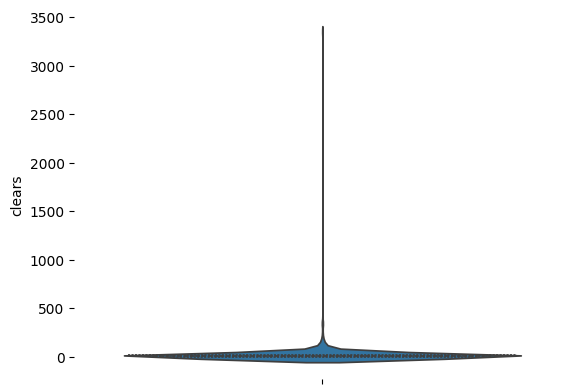

In [5]:
#Plot the distribution of clears
sns.violinplot(level_data_df.clears, inner='quart')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

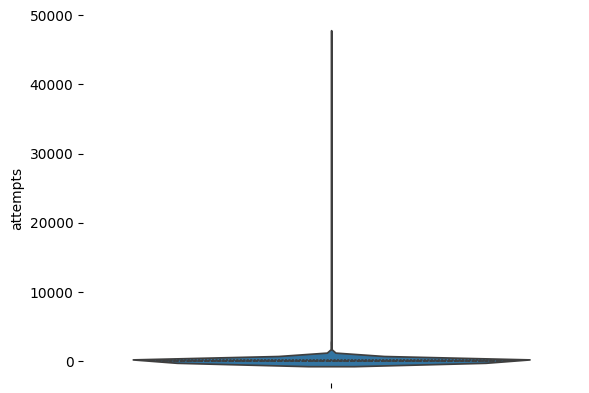

In [6]:
#Plot the distribution of attempts
sns.violinplot(level_data_df.attempts, inner='quart')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

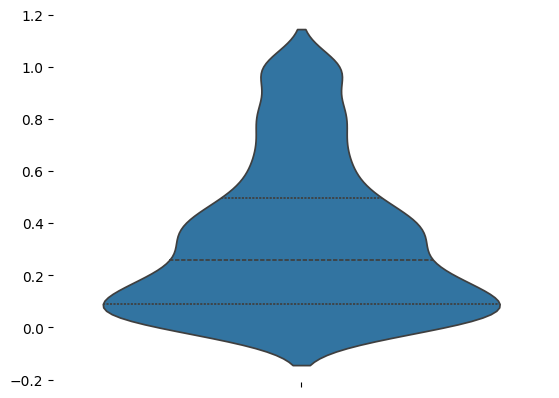

In [21]:
#Plot the distribution of clear rate
sns.violinplot(level_data_df.clears / level_data_df.attempts, inner='quart')
sns.despine(top=True, right=True, bottom=True, left=True) #removes border box in plot

<Axes: >

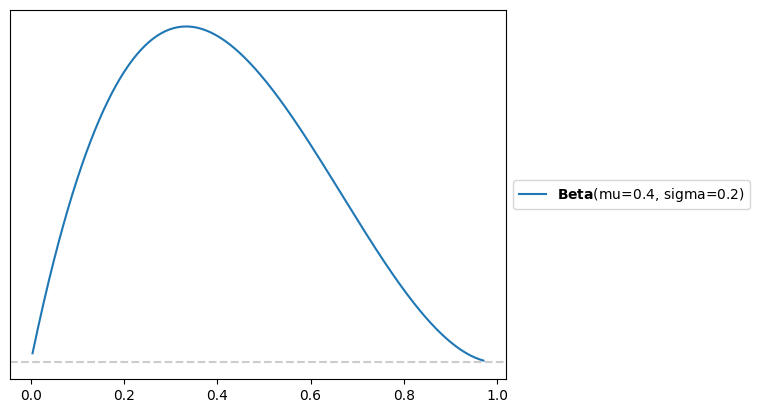

In [26]:
#Define the mu hyperprior probability density function based on clear rate
prior_pdf_μ = pz.Beta(mu=0.4, sigma=0.2)
prior_pdf_μ.plot_pdf()

<Axes: >

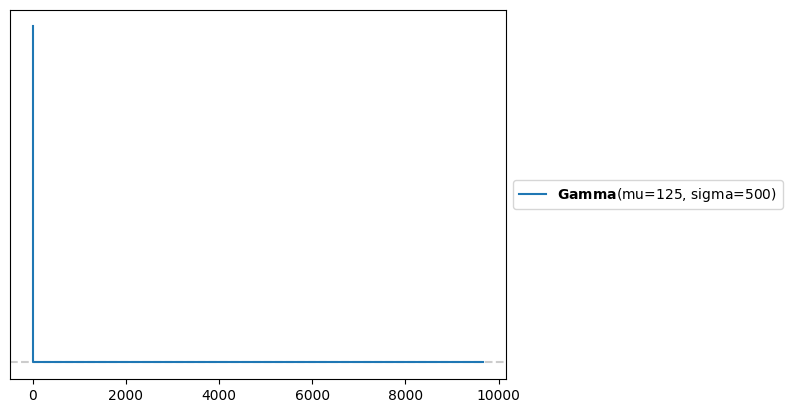

In [23]:
#Define the nu hyperprior probability density function based on attempts
prior_pdf_ν = pz.Gamma(mu = level_data_df.attempts.mean(), sigma = 500)
prior_pdf_ν.plot_pdf()

Here, I convert the difficulty grouping into the forms pymc will need.

In [7]:
#Get the an array of difficulties
difficulty_idx = level_data_df.difficulty.cat.codes.values
print(difficulty_idx)

#Get an array of the difficulty values
difficulty_codes = level_data_df.difficulty.cat.categories
print(difficulty_codes)

#Put the coordinates in a dictionary for pymc
difficulty_coords = {"difficulty": difficulty_codes}
print(difficulty_coords)

[0 3 1 1 1 0 2 1 1 1 0 1 0 0 0 0 1 2 1 1 1 1 1 1 0 1 1 1 1 1 1 3 1 1 0 1 0
 1 0 2 0 2 1 1 2 3 0 2 1 1 2 0 1 1 0 0 0 1 1 0 2 2 1 0 1 1 2 2 0 1 1 1 1 0
 0 0 1 1 1 1 1 0 1 2 1 1 0 0 0 1 2 0 1 2 1 1 1 1 1 0 0 0 0 1 0 2 0 1 1 1 0
 1 3 1 0 0 0 1 3 0 0 0 1 1 0 0 0 1 1 1 1 0 0 2 1 1 0 0 0 2 0 3 1 1 1 1 1 1
 0 0 0 1 0 0 1 1 1 0 1 0 3 2 0 2 0 2 1 0 2 0 1 1 0 1 0 1 2 0 1 0 3 0 2 1 0
 1 0 1 1 2 2 1 1 3 0 1 1 1 1 0 1 1 1 0 1 0 1 0 0 2 0 2 1 0 0 1 1 2 0 2 0 2
 1 1 0 1 0 3 1 0 1 1 1 2 0 1 3 0 0 0 2 0 1 1 0 1 1 1 0 0 1 3 0 1 0 1 1 1 1
 1 0 1 1 0 1 0 2 1 0 1 3 2 1 0 1 2 2 0 3 0 3 1 1 1 2 0 0 0 0 0 0 1 0 1 1 1
 2 1 1 1 2 3 2 1 0 1 0 1 1 1 2 0 1 3 0 1 1 0 1 0 0 0 0 0 0 3 1 2 1 2 1 0 0
 1 0 2 2 0 0 1 1 1 1 0 2 0 0 1 0 3 1 1 0 1 1 0 1 0 1 1 0 1 1 3 0 0 2 1 1 2
 1 1 3 0 1 2 1 2 2 1 1 2 0 1 1 0 3 0 0 1 2 2 1 2 0 1 2 1 1 2 0 0 1 0 0 2 1
 2 2 1 1 0 0 3 1 1 3 1 2 0 1 0 0 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 0 1 0 0
 0 1 2 2 0 1 1 2 1 1 2 1 1 2 0 0 1 1 1 1 1 1 1 0 1 3 0 0 1 3 0 2 1 1 2 0 1
 1 2 1 2 1 1 1 0 2 3 0 1 

The pymc model will be created with previously described hyperpriors for a set of beta distributions parameterized by mu and nu grouped by difficulty. The likelihood is a binomial model with n as the number of attempts, p defined by the beta priors, and observed data defined by the clears.

In [29]:
#Clear rate abbrieviated cr
with pm.Model(coords=difficulty_coords) as cr_model:
    #Feed the previously defined hyperpriors to pymc
    μ = prior_pdf_μ.to_pymc("μ")
    ν = prior_pdf_ν.to_pymc("ν")

    #Priors for difficulties
    μ_p = pm.Beta('μ_p', mu = μ, nu = ν, dims = "difficulty")

    ν_p = pm.Gamma('ν_p', mu = prior_pdf_ν.mu, sigma = prior_pdf_ν.mu, dims="difficulty")

    # Parameter for levels
    θ = pm.Beta('θ', mu = μ_p[difficulty_idx], nu = ν_p[difficulty_idx])

    #This tells our model how many attempts and clears each level has
    _ = pm.Binomial('gs',
                    n = level_data_df.attempts.values, #attempts for each level
                    p = θ, #guess of clears per attempt
                    observed = level_data_df.clears.values) #clears per level

    #target_accept has a default of 0.8. Increasing it makes us less likely to
    #have divergences
    idata_cr = pm.sample(target_accept = 0.95)

Output()

Output()

The posterior distributions for expected clear rate are displayed in the following plot. As a reminder, 0 is easy and 3 is super expert. The clear rate of easy levels is modelled at about 63%. Normal levels are much lower at only around 23%. Expert levels are around 5% and super expert close to 1%. The lower the difficulty, the smaller the hdi, and the more unsure the model seems about what the exact expected clear rate may be.

array([<Axes: >], dtype=object)

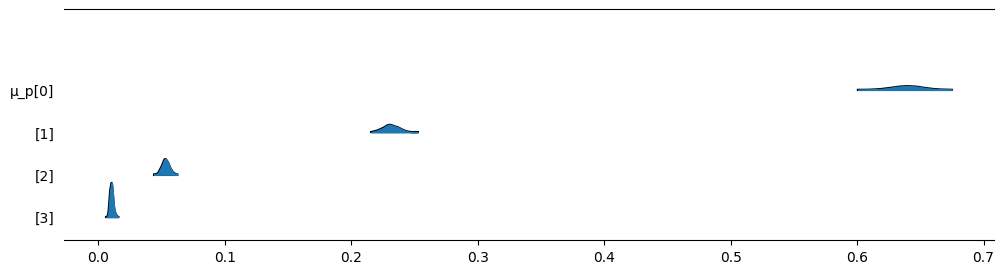

In [30]:
#Plot a 99.8% HDI for the expected clear rate grouped by difficulty
az.plot_forest(idata_cr, var_names=['μ_p'], combined=True, figsize=(12, 3), kind = 'ridgeplot', hdi_prob=0.998)

The posterior predictive check reveals the model predictions are close to the observed data. The prediction lines center on the observed line and do not vary wildly from it. Confidence may be placed in the model's predictions.

In [41]:
pm.sample_posterior_predictive(idata_cr, model=cr_model, extend_inferencedata=True)

Output()

Inference data with groups:
	> posterior
	> posterior_predictive
	> sample_stats
	> observed_data

<Axes: xlabel='gs'>

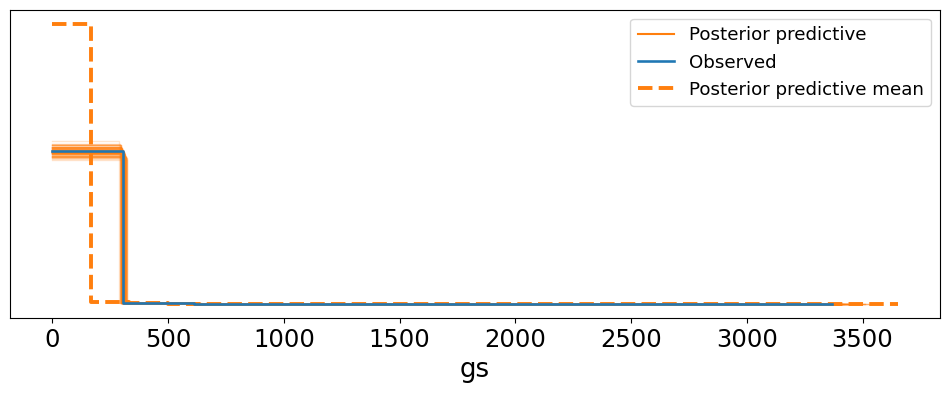

In [43]:
az.plot_ppc(idata_cr, num_pp_samples=100, figsize=(12, 4), colors=["C1", "C0", "C1"])

Below, the markov chains for the posterior model can be visualized along with the r hat values for each prior. The r hat values seem good, as they appear below 1.01. The majority of the plot trace curves have a consistent amplitude and are tightly packed, which is another indicator that confidence can be placed in the model.

array([[<Axes: title={'center': 'θ'}>, <Axes: title={'center': 'θ'}>],
       [<Axes: title={'center': 'μ'}>, <Axes: title={'center': 'μ'}>],
       [<Axes: title={'center': 'μ_p'}>, <Axes: title={'center': 'μ_p'}>],
       [<Axes: title={'center': 'ν'}>, <Axes: title={'center': 'ν'}>],
       [<Axes: title={'center': 'ν_p'}>, <Axes: title={'center': 'ν_p'}>]],
      dtype=object)

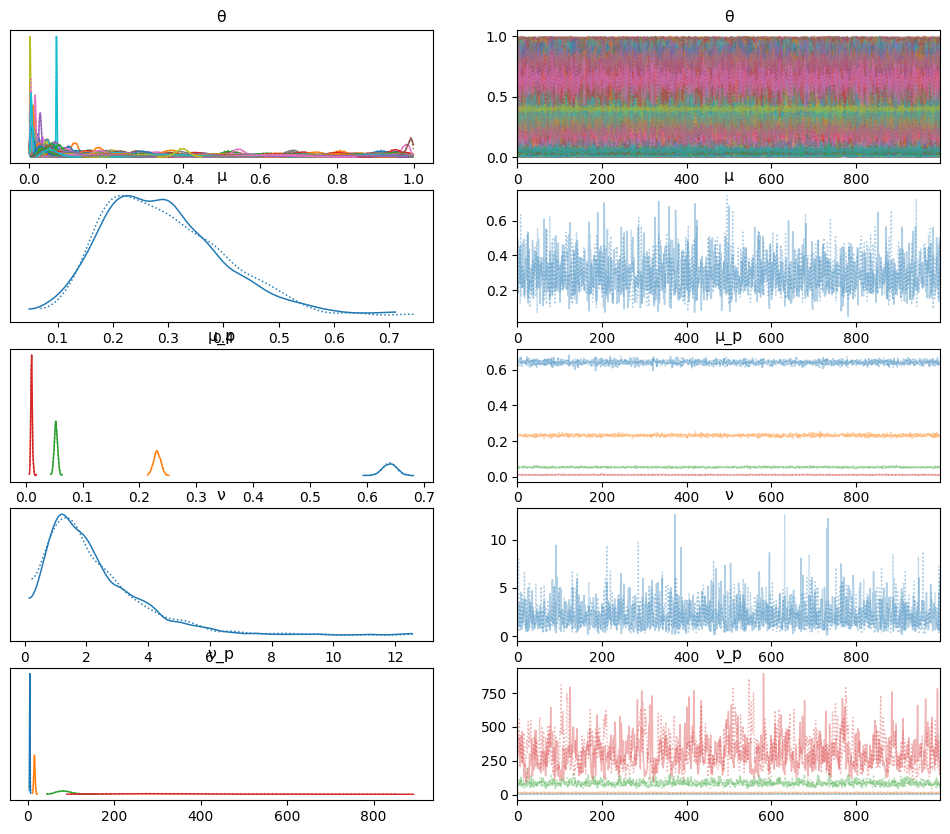

In [31]:
#Visualize markov chains
az.plot_trace(idata_cr)

In [32]:
#Using arviZ to find the rhat values
az.rhat(idata_cr)

<xarray.Dataset> Size: 16kB
Dimensions:     (θ_dim_0: 1000, difficulty: 4)
Coordinates:
  * θ_dim_0     (θ_dim_0) int64 8kB 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * difficulty  (difficulty) int64 32B 0 1 2 3
Data variables:
    θ           (θ_dim_0) float64 8kB 0.9996 0.9997 1.001 ... 0.9996 1.002 1.005
    μ           float64 8B 1.003
    μ_p         (difficulty) float64 32B 1.002 1.001 0.9999 1.002
    ν           float64 8B 0.9995
    ν_p         (difficulty) float64 32B 1.002 0.9996 1.0 1.005